### Welcome to my notebook comparing the temperature anomalies at our local boeing field in the last ~50 years to the historical Northern Hemisphere temperature anomalies.

#### You can start at cell 19, if you don't want to see all the code / EDA around getting the Boeing data to a place where I can compare it to the Northern Hemisphere data.

## Imports & Make it Pretty

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scs

import anomalies as a

#make it pretty
plt.style.use('ggplot')

%matplotlib inline


## Data Data and ... More Data

In [2]:
# unless otherwise noted :  data sets are 2009 June 1 - 2019 May 31 = dataset 2009
df_2009 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1749343.csv", low_memory=False)
df_1999 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1749348.csv", low_memory=False)
df_1989 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1749350.csv", low_memory=False)
# 1973 - 1979
df_1973 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1979.csv", low_memory=False)
# 1964 - 1973 - no idea why they weren't in the other data sets ...
df_missing = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/test.csv", low_memory=False)
# 1959 - 1964
df_1959 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1969.csv", low_memory=False)
df_1949 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1959.csv", low_memory=False)
# october 1943 - May 31 1949
df_1943 = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/1949.csv", low_memory=False)


#### Do Stuff with the Data and Functions
## Take some columns from all Datasets and make 1 Dataset 

In [3]:
# list of all datasets:
lst_1949_2019 = [df_1943, df_1949, df_1959, df_missing, df_1973, df_1989, df_1999, df_2009]

In [4]:
# list of all columns I want to include:
lst_cols = ["DATE","MonthlyMeanTemperature", "MonthlyMaximumTemperature", "MonthlyMinimumTemperature", "ShortDurationPrecipitationValue150", "DailyAverageDryBulbTemperature", "HourlyDryBulbTemperature", "TStorms", "MonthlyTotalSnowfall", "DailySnowfall", "DailySnowDepth"]


In [5]:
# get only cols I want
col_dfs = [x[lst_cols] for x in lst_1949_2019]

In [6]:
# combine all dfs into one df
all_dfs = pd.concat(col_dfs, axis=0)

In [7]:
# check that they all combined
all_dfs.shape
#all_dfs.head()

(525458, 11)

In [10]:
# remove null values and get year and month columns with function in .py file
all_dfs_no_null = a.no_more_null(all_dfs, "HourlyDryBulbTemperature", "DailyAverageDryBulbTemperature")

# check to see how many rows we lost
all_dfs_no_null.shape

# lost ~ 50,000 rows by doing no null Hourly Dry Bulb Temperature ~ 10 percent of hour/dates


(483636, 11)

In [12]:
# check for overlap in dates in datasets - drop all but first 

drop_duplicate_dates = (all_dfs_no_null.drop_duplicates("DATE")).copy()
drop_duplicate_dates.shape


(471064, 11)

In [13]:
# now we have all the data 10/1943 - 5/2019 duplicate dates removed, rows with null HourlyDryBulbTemperature removed

# want the average yearly temperature 1/1952 - 12/1999 to use as the base for the temperature anomaly equation

# first need to make year and month columns
# mega_dfs = no null HourlyDryBulbTemperature, no duplicate dates, year and month cols
mega_dfs = a.year_month_cols(drop_duplicate_dates)


In [14]:
# set indices to the inverse of the following:
# which says - if you looked at the value as a string, would the last character be numeric - boolean
indices = (~mega_dfs["HourlyDryBulbTemperature"].astype(str).str[-1].str.isnumeric())

# so, all the values that don't have a last character that is numeric will have the last character removed
mega_dfs.loc[indices,"HourlyDryBulbTemperature"] = mega_dfs.loc[indices,"HourlyDryBulbTemperature"].str[:-1]

# some values in HourlyDryBulbTemperature were numeric strings ending with 's' that needed the 's' removed
# before they could be converted to floats

mega_dfs["HourlyDryBulbTemperature"] = mega_dfs["HourlyDryBulbTemperature"].map(lambda x:float(x) if x!="" else np.nan)

indices =  (~mega_dfs["HourlyDryBulbTemperature"].isna())
mega_dfs2 = mega_dfs.loc[indices] 

# mega_dfs2 should no longer have empty strings or na


In [15]:
# setting year parameters for Base DF == 1952 - 1999
ba_df = pd.DataFrame(mega_dfs2[mega_dfs2["year"] < 2000 ])
b_df = pd.DataFrame(ba_df[ba_df["year"] > 1951])

# get mean of HourlyDryBulbTemperature for Base Years
# need to reset index so I can sort by year
base_df = b_df.reset_index()
#base_df["HourlyDryBulbTemperature"].dtype


In [16]:
# set the value (back) to floats and get the mean of the Base Years
base_df["HourlyDryBulbTemperature"] = base_df["HourlyDryBulbTemperature"].astype(float)
base_mean = base_df["HourlyDryBulbTemperature"].mean()
base_mean


52.89116185400442

In [17]:
# convert to celsius so I can compare to the paleo dataset
mega_year = pd.DataFrame(mega_dfs2[["year","HourlyDryBulbTemperature"]])
year_ms = mega_year.groupby("year")
year_means = pd.DataFrame(year_ms["HourlyDryBulbTemperature"].mean())

# (32°F − 32) × 5/9 = 0°C

year_means["mean temp in C"] = year_means["HourlyDryBulbTemperature"].map(lambda x:((x-32)*(5/9)))


# diff between base_mean and year_mean
year_means["raw_anomaly"] = year_means["mean temp in C"] - ((base_mean-32)*(5/9))

year_means = year_means.reset_index()

#take out 1943 and 2019 b/c they aren't full years
year_means = year_means.iloc[1:53,:]

# 2003 aka index 37 is also incomplete
year_means = year_means.drop(37)
year_means.head()

,year,HourlyDryBulbTemperature,mean temp in C,raw_anomaly
1,1944,51.586045,10.881136,-0.725065
2,1948,50.481203,10.267335,-1.338866
3,1949,51.144603,10.635891,-0.970310
4,1950,50.970971,10.539429,-1.066772
5,1951,51.826350,11.014639,-0.591562


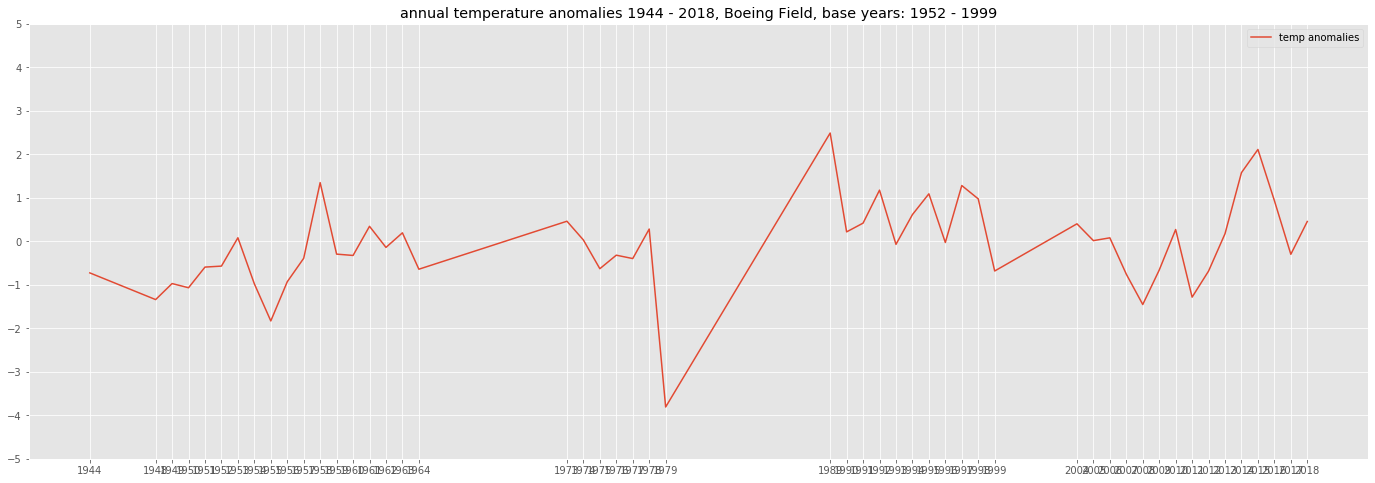

In [18]:
# plot temperature anomaly for 1944-2018

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot(year_means['year'],year_means["raw_anomaly"] , label = "temp anomalies")
ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])

ax.set_xticks(year_means['year'])
ax.set_title("annual temperature anomalies 1944 - 2018, Boeing Field, base years: 1952 - 1999")
ax.legend(loc='best')

plt.show()

### You can start here if you don't want to go through the "conforming the local data to the N. Hemisphere data" part

In [19]:
# only year, month, and HourlyDryBulbTemperature 
ymhdbt = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/boeing_field_ymhdbt.csv")


In [20]:
# subsets from LCD: lists of tuples (year, mean) only years w/ 12 months represented, function weights equally

means48_64 = a.months_equally_weighted(ymhdbt, range(1948,1965), "HourlyDryBulbTemperature")
means73_78 = a.months_equally_weighted(ymhdbt, range(1973,1979), "HourlyDryBulbTemperature")
means90_99 = a.months_equally_weighted(ymhdbt, range(1990,2000), "HourlyDryBulbTemperature")
means04_18 = a.months_equally_weighted(ymhdbt, range(2004,2019), "HourlyDryBulbTemperature")

In [21]:
# lists of years for each subset of LCD

years48_64 = [x[0] for x in means48_64]
years73_78 = [x[0] for x in means73_78]
years90_99 = [x[0] for x in means90_99]
years04_18 = [x[0] for x in means04_18]


In [22]:
# LCD year comparison (temperature anomaly yearly) = year_mean - base_mean
# as list for plotting

anomaly48_64 = list(map(lambda x:x[1]- base_mean, means48_64))
anomaly73_78 = list(map(lambda x:x[1]- base_mean, means73_78))
anomaly90_99 = list(map(lambda x:x[1]- base_mean, means90_99))
anomaly04_18 = list(map(lambda x:x[1]- base_mean, means04_18))


In [23]:
# bring in data from paleoclimatology dataset

df = pd.read_csv("/Users/sarahburgart/galvanize/week4 - capstone 1/data/shi2013nh.txt",sep="\t", low_memory=False, comment='#')

# create subsets parallel to years in LCD subsets

paleo48_64 = df[(df["age_AD"] > 1947) & (df["age_AD"] < 1965)][["age_AD", "tempanom-ann"]]
paleo73_78 = df[(df["age_AD"] > 1972) & (df["age_AD"] < 1979)][["age_AD", "tempanom-ann"]]
paleo90_99 = df[(df["age_AD"] > 1989) & (df["age_AD"] < 2000)][["age_AD", "tempanom-ann"]]


In [24]:
paleo48_64.head()

,age_AD,tempanom-ann
948,1948,-0.032
949,1949,-0.027
950,1950,-0.025
951,1951,-0.020
952,1952,-0.008


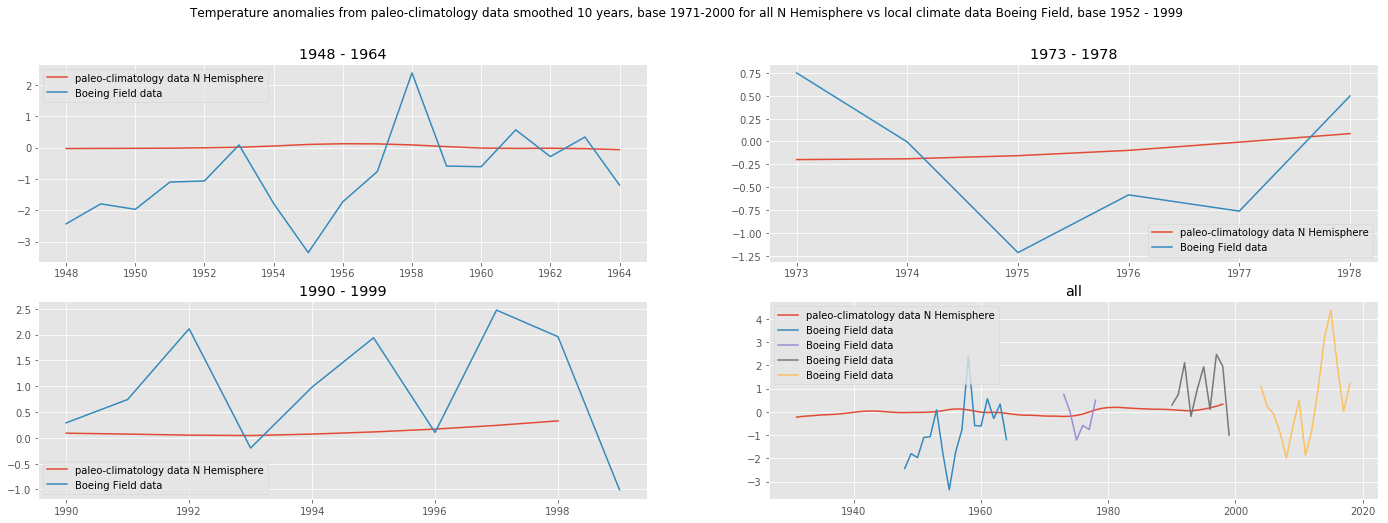

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(24, 8))
a = axs.flatten()
a[0].plot(paleo48_64["age_AD"], paleo48_64["tempanom-ann"], label= "paleo-climatology data N Hemisphere")
a[0].plot(paleo48_64["age_AD"], anomaly48_64, label= "Boeing Field data")
a[0].set_title("1948 - 1964")
a[0].legend(loc='best')

a[1].plot(paleo73_78["age_AD"], paleo73_78["tempanom-ann"], label= "paleo-climatology data N Hemisphere")
a[1].plot(paleo73_78["age_AD"], anomaly73_78, label= "Boeing Field data")
a[1].set_title("1973 - 1978")
a[1].legend(loc='best')

a[2].plot(paleo90_99["age_AD"], paleo90_99["tempanom-ann"], label= "paleo-climatology data N Hemisphere")
a[2].plot(paleo90_99["age_AD"], anomaly90_99, label= "Boeing Field data")
a[2].set_title("1990 - 1999")
a[2].legend(loc='best')

a[3].plot(df[df["age_AD"] > 1930][["age_AD"]], df[df["age_AD"] > 1930][["tempanom-ann"]], label= "paleo-climatology data N Hemisphere")
a[3].plot(years48_64, anomaly48_64, label= "Boeing Field data")
a[3].plot(years73_78, anomaly73_78, label= "Boeing Field data")
a[3].plot(years90_99, anomaly90_99, label= "Boeing Field data")
a[3].plot(years04_18, anomaly04_18, label= "Boeing Field data")
a[3].set_title("all")
a[3].legend(loc='best')



fig.suptitle('Temperature anomalies from paleo-climatology data smoothed 10 years, base 1971-2000 for all N Hemisphere vs local climate data Boeing Field, base 1952 - 1999')
plt.show()



In [25]:
# mann whitney test - no smoothing
# alpha = .05 
# In statistics, the Mann–Whitney U test (also called the Mann–Whitney–Wilcoxon (MWW), 
#Wilcoxon rank-sum test, or Wilcoxon–Mann–Whitney test) is a nonparametric test of the null hypothesis 
#that it is equally likely that a randomly selected value f
#rom one sample will be less than or greater than a randomly selected value from a second sample.


pvalue48_64 = scs.mannwhitneyu(paleo48_64["tempanom-ann"], anomaly48_64)
pvalue73_78 = scs.mannwhitneyu(paleo73_78["tempanom-ann"], anomaly73_78)
pvalue90_99 = scs.mannwhitneyu(paleo90_99["tempanom-ann"], anomaly90_99)

print(f"For full years in LCD compared to same years in paleo set:\npvalue for 1948 - 1964: {pvalue90_99[1]}\npvalue for 1973 - 1978: {pvalue73_78[1]}\npvalue for 1990 - 1999: {pvalue90_99[1]}")


For full years in LCD compared to same years in paleo set:
pvalue for 1948 - 1964: 0.10606095893069767
pvalue for 1973 - 1978: 0.4680931467365297
pvalue for 1990 - 1999: 0.10606095893069767


In [26]:
# rate of change 1948 - 1999 compare

# np.diff for yearly mean (slope between yearly means)
prates = []
prates.append(list(np.diff(x) for x in [paleo48_64["tempanom-ann"].values]))
prates.append(list(np.diff(x) for x in [paleo73_78["tempanom-ann"].values]))
prates.append(list(np.diff(x) for x in [paleo90_99["tempanom-ann"].values]))

# leave off last list bc there is not an equal list in p_list
lcd_list = [anomaly48_64, anomaly73_78, anomaly90_99]
lcdrates = [np.diff(x) for x in lcd_list]

# list of years to plot against
yearsets = [paleo48_64["age_AD"].values, paleo73_78["age_AD"].values, paleo90_99["age_AD"].values]


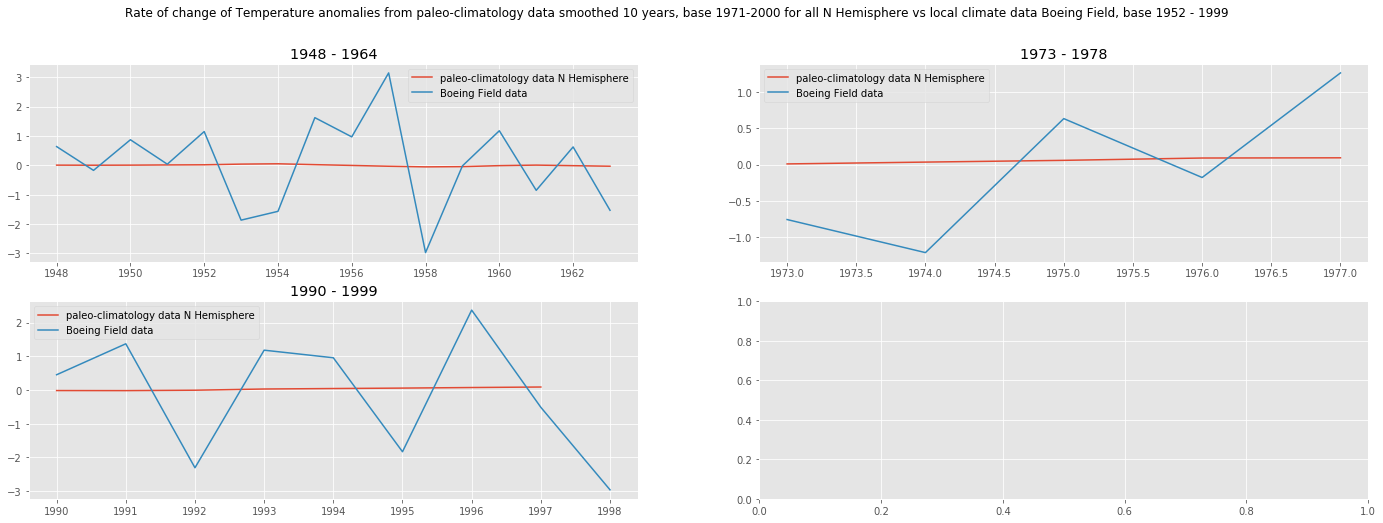

In [27]:
# plot rate of change for each subset

fig, axs = plt.subplots(2, 2, figsize=(24, 8))

for p, lcd, year, idx, ax in zip(prates, lcdrates, yearsets, [0,1,2,3], axs.flatten()):
    ax.plot(year[:-1], np.array(p).reshape(-1,1), label= "paleo-climatology data N Hemisphere")
    ax.plot(year[:-1], lcd, label= "Boeing Field data")
    ax.set_title(f"{year[0]} - {year[-1]}")
    ax.legend(loc='best')

fig.suptitle('Rate of change of Temperature anomalies from paleo-climatology data smoothed 10 years, base 1971-2000 for all N Hemisphere vs local climate data Boeing Field, base 1952 - 1999')
plt.show()

In [28]:
# mann whitney test - no smoothing
# alpha = .05  paleo90_99["tempanom-ann"]  anomaly90_99


pvaluerate48_64 = scs.mannwhitneyu(prates[0][0], lcdrates[0])
pvaluerate73_78 = scs.mannwhitneyu(prates[1][0], lcdrates[1])
pvaluerate90_99 = scs.mannwhitneyu(prates[2][0], lcdrates[2])

print(f"For full years in LCD compared to same years in paleo set:\npvalue for slopes 1948 - 1964: {pvalue90_99[1]}\npvalue for slopes 1973 - 1978: {pvalue73_78[1]}\npvalue for slopes 1990 - 1999: {pvalue90_99[1]}")


For full years in LCD compared to same years in paleo set:
pvalue for slopes 1948 - 1964: 0.10606095893069767
pvalue for slopes 1973 - 1978: 0.4680931467365297
pvalue for slopes 1990 - 1999: 0.10606095893069767


In [29]:
len (df)
len( df[df["tempanom-ann"] < 999][["tempanom-ann"]] )
paleo = df[df["tempanom-ann"] < 999]
type(paleo["tempanom-ann"])

paleo_same = paleo[paleo["age_AD"] > 1943]
len( paleo_same["tempanom-ann"] )


anomaly48_64 = list(map(lambda x:x[1]- base_mean, means48_64))
anomaly73_78 = list(map(lambda x:x[1]- base_mean, means73_78))
anomaly90_99 = list(map(lambda x:x[1]- base_mean, means90_99))
anomaly04_18 = list(map(lambda x:x[1]- base_mean, means04_18))

year_means["year"]

a_for_lr = anomaly48_64+ anomaly73_78+anomaly90_99+anomaly04_18
ay_for_lr = years48_64+years73_78+years90_99+years04_18

#a_for_lr = [int(x) for x in a_lr]
#(a_for_lr)

slope: -0.000032    intercept: -0.333513
R-squared: 0.002585


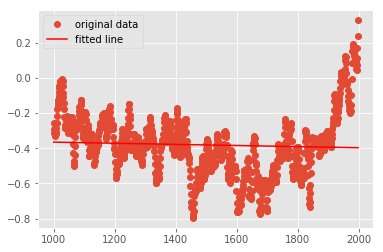

In [30]:
paleo = df[df["tempanom-ann"] < 999]
paleo_same = paleo[paleo["age_AD"] > 1943]

x = np.array(paleo["age_AD"])
y = np.array(paleo["tempanom-ann"])

slope, intercept, r_value, p_value, std_err = scs.linregress(x, y )
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

slope: 0.004345    intercept: -8.552569
R-squared: 0.213469


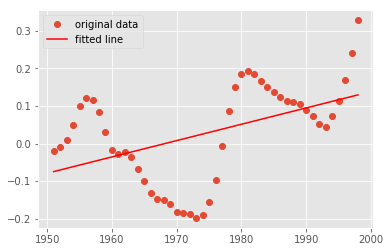

In [37]:
paleo = df[df["tempanom-ann"] < 999]
paleo_same = paleo[paleo["age_AD"] > 1950]

x = np.array(paleo_same["age_AD"])
y = np.array(paleo_same["tempanom-ann"])

slope, intercept, r_value, p_value, std_err = scs.linregress(x, y )
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

slope: 0.031560    intercept: -62.601809
R-squared: 0.235434


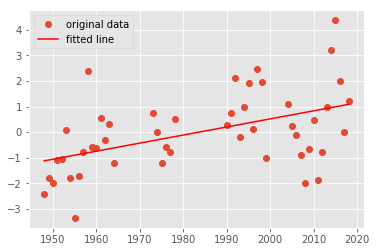

In [32]:
# exactly the same as the pvalues for the means

# linear regression fit line != the same - very different results --> bears looking into more

# needs to be np.array if multiply by float!!!!

# use only years that have all of them
#print(ay_for_lr, a_for_lr)
#print(scs.linregress(range(55), paleo_same["tempanom-ann"]))


x = np.array(ay_for_lr)
y = a_for_lr


slope, intercept, r_value, p_value, std_err = scs.linregress(x, y )

print("slope: %f    intercept: %f" % (slope, intercept))

print("R-squared: %f" % r_value**2)
plt.plot(x, y, 'o', label='original data')

#12.2*np.array([1,2,3,4])

plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Citations:

#### Paleo-Climatology Dataset:
##### Original Publication:
1,000 Year Ensemble Reconstructions of Temperature and CO2
Originator:
Frank, D.C.; Esper, J.; Raible, C.C.; Büntgen, U.; Trouet, V.; Stocker, T.F.; Joos, F.
Citation Information:
Frank, D.C., J. Esper, C.C. Raible, U. Büntgen, V. Trouet, B. Stocker, and F. Joos. 2010. Ensemble reconstruction constraints on the global carbon cycle sensitivity to climate. 
Nature, Vol. 463, pp.527-532, 28 January 2010. doi:10.1038/nature08769
##### Online Resource:
NOAA, National Center for Environmental Information
https://www.ncdc.noaa.gov/paleo-search/study/10437
##### Dataset & Publication DOIs:
2010, Nature, Vol. 463, pp.527-532, 28 January 2010. doi:10.1038/nature08769
##### Date Accessed:
May 24, 2019
    
Data Coverage:
Southernmost Latitude: 0 
Northernmost Latitude: 90 
Westernmost Longitude: -180 
Easternmost Longitude: 180 
Minimum Elevation: Unknown 
Maximum Elevation: Unknown 
Earliest Year: 950 cal yr BP (1000 CE) 
Most Recent Year: -45 cal yr BP (1995 CE)    

#### LCD Dataset:
boeing field lat /long : 47.5282° N, 122.3018° W  <--- almost middle of N. Hemisphere latitudes
##### Online Resource:
NOAA, National Center for Environmental Information, DataTools: Local Climatological Data (LCD)
https://www.ncdc.noaa.gov/cdo-web/datatools/lcd

s = suspect value (appears with value) <-- chose to keep these, after removing the null, nan, ~526000 -->460000

### To Do ...

- smooth LCD data with same 10 year interval as the Paleo data
    - redo the Mann-Whitney test with smoothed data
- add data from other nearby stations - either do mean of all or find lowest # of available data points for any
  day and sample that many from each day / month / year
    - redo Mann-Whit test with this data, smooth it, do it again
- fit a line to LCD data and compare with paleo data for the overlapping years
    - use this to hypothesize what the climate was like in Seattle 1000 years ago
- fit line to paleo data and use it to compare with 1999 - 2018 data for Seattle (this could change above equation)
- read in data from other paleo sets - either for the same area or smaller, compare to Seattle sets

In [50]:
# This is a two-sided test for the null hypothesis 
# that 2 independent samples are drawn from the same continuous distribution.


paleo_same



scs.ks_2samp(paleo_same["tempanom-ann"], a_for_lr)



Ks_2sampResult(statistic=0.4791666666666667, pvalue=1.7074278357520742e-05)